# Advent of code 2017

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2017/advent_of_code_2017.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2017/advent_of_code_2017.ipynb)
with Python solutions to the
[2017 Advent of Code puzzles](https://adventofcode.com/2017),
completed in November 2022,
by [Hugues Hoppe](http://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 2 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results:

<p>
<a href="#day11">day11</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2017/results/day11.png" width="256"> &emsp;
<a href="#day14">day14</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2017/results/day14.png" width="256">
</p>
<p>
<a href="#day19">day19</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2017/results/day19.gif" width="340"> &emsp;
<a href="#day22">day22</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2017/results/day22.png" width="320">
</p>
<p>
<a href="#day21">day21</a> <img src="https://github.com/hhoppe/advent_of_code/raw/main/2017/results/day21.png" width="800">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-hhoppe hhoppe-tools mediapy more-itertools numba numpy

In [3]:
from __future__ import annotations

import collections
from collections.abc import Iterator
import dataclasses
import functools
import graphlib
import itertools
import math
import operator
import pathlib
import re
import sys
import types
from typing import Any, Tuple

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import more_itertools
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2017
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
if 1:
  hh.run(
      '{ [ -d data ] || mkdir data; } && cd data &&'
      f' {{ [ -f {PROFILE}.tar.gz ] || wget -q {TAR_URL}; }} &&'
      f' tar xzf {PROFILE}.tar.gz'
  )
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session (auth login) cookie:
if 0:
  # echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq

In [13]:
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Digits in a circular list

- Part 1: Find the sum of all digits that match the next digit in the list.

- Part 2: Instead of considering the next digit, consider the digit halfway around the circular list.

In [14]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2017/day/1), `puzzle.input` has a single line of 2_118 characters:

11183136235455117313495775841784971687718871633822712186999265297215465163229667 ... 66515428245928111112613638341345371


The stored answers are: `{1: '1044', 2: '1054'}`

In [15]:
def day1(s, *, part2=False):
  digits = [int(ch) for ch in s.strip()]
  total = 0
  offset = len(digits) // 2 if part2 else 1
  for d0, d1 in zip(digits, digits[offset:] + digits[:offset]):
    if d0 == d1:
      total += d0
  return total


check_eq(day1('1122'), 3)
check_eq(day1('1111'), 4)
check_eq(day1('1234'), 0)
check_eq(day1('91212129'), 9)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2('1212'), 6)
check_eq(day1_part2('1221'), 0)
check_eq(day1_part2('123425'), 4)
check_eq(day1_part2('123123'), 12)
check_eq(day1_part2('12131415'), 4)
puzzle.verify(2, day1_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Rows of numbers

- Part 1: Find sum of differences between largest and smallest value in each row.

- Part 2: Find in each row the only 2 numbers where one evenly divides the other.  Sum the divisions.

In [16]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2017/day/2), `puzzle.input` has 16 lines:

798	1976	1866	1862	559	1797	1129	747	85	1108	104	2000	248	131	87	95
201	419	336	65	208	57	74	433	68	360	390	412	355	209	330	135
967	84	492	1425	1502	1324	1268	1113	1259	81	310	1360	773	69	68	290
169	264	107	298	38	149	56	126	276	45	305	403	89	179	394	172
3069	387	2914	2748	1294	1143	3099	152	2867	3082	113	145	2827	2545	134	469
3885	1098	2638	5806	4655	4787	186	4024	2286	5585	5590	215	5336	2738	218	266
661	789	393	159	172	355	820	891	196	831	345	784	65	971	396	234
4095	191	4333	161	3184	193	4830	4153	2070	3759	1207	3222	185	176	2914	4152
 ...
271	4026	2960	6444	2896	228	819	676	6612	6987	265	2231	2565	6603	207	6236
91	683	1736	1998	1960	1727	84	1992	1072	1588	1768	74	58	1956	1627	893
3591	1843	3448	1775	3564	2632	1002	3065	77	3579	78	99	1668	98	2963	3553
2155	225	2856	3061	105	204	1269	171	2505	2852	977	1377	181	1856	2952	2262


The stored answers are: `{1: '41919', 2: '303'}`

In [17]:
s1 = """\
5 1 9 5
7 5 3
2 4 6 8
"""

In [18]:
s2 = """\
5 9 2 8
9 4 7 3
3 8 6 5
"""

In [19]:
def day2(s, *, part2=False):
  total = 0

  for line in s.splitlines():
    values = [int(field) for field in line.split()]
    if not part2:
      difference = max(values) - min(values)
      total += difference
    else:
      for value1, value2 in itertools.permutations(values, 2):
        if value1 % value2 == 0:
          total += value1 // value2
          break

  return total


check_eq(day2(s1), 18)
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s2), 9)
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Spiral memory

- Part 1: Find the Manhattan distance (from the origin) of the nth spiral entry.

- Part 2: Successively, each spiral value is the sum of its 3x3 neighborhood; find the first value that is larger than the puzzle input.

In [20]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2017/day/3), `puzzle.input` has a single line of 6 characters:

312051


The stored answers are: `{1: '430', 2: '312453'}`

In [21]:
def day3_spiral_yx():
  """Yields y, x coordinates of successive spiral entries."""
  yield 0, 0  # Value 1.
  yield 0, 1  # Value 2.
  yield -1, 1  # Value 3.
  y, x = -1, 1
  arm = 2
  while True:
    for _ in range(arm):
      x -= 1
      yield y, x
    for _ in range(arm):
      y += 1
      yield y, x
    arm += 1
    for _ in range(arm):
      x += 1
      yield y, x
    for _ in range(arm):
      y -= 1
      yield y, x
    arm += 1

In [22]:
def day3_part1_slow(s):
  value = int(s)
  y, x = next(itertools.islice(day3_spiral_yx(), value - 1, None))
  return abs(y) + abs(x)


check_eq(day3_part1_slow('1'), 0)
check_eq(day3_part1_slow('12'), 3)
check_eq(day3_part1_slow('22'), 3)
check_eq(day3_part1_slow('23'), 2)
check_eq(day3_part1_slow('24'), 3)
check_eq(day3_part1_slow('1024'), 31)
puzzle.verify(1, day3_part1_slow)

(Part 1: 0.013 s)


In [23]:
def day3_part1(s):
  value = int(s)
  result = {1: 0, 2: 1, 3: 2}.get(value)
  if result is not None:
    return result
  n = 4
  arm = 2
  count = 0  # 0 or 1
  while n + arm <= value:
    n += arm
    count += 1
    if count == 2:
      count = 0
      arm += 1
  xd = value - n - (arm // 2 - 1)
  r = (arm + count) // 2
  d = abs(xd) + r
  return d


check_eq(day3_part1('1'), 0)
check_eq(day3_part1('12'), 3)
check_eq(day3_part1('22'), 3)
check_eq(day3_part1('23'), 2)
check_eq(day3_part1('24'), 3)
check_eq(day3_part1('1024'), 31)
puzzle.verify(1, day3_part1)

(Part 1: 0.000 s)


In [24]:
def day3_part2(s, *, size=41):
  value = int(s)
  grid = np.zeros((size, size), np.int32)
  g = size // 2  # The first value 1 is located at central grid[g, g].
  for y0, x0 in day3_spiral_yx():
    y, x = y0 + g, x0 + g
    assert y >= 1 and x >= 1
    count = max(np.sum(grid[y - 1 : y + 2, x - 1 : x + 2]), 1)
    grid[y, x] = count
    if count > value:
      return count

  raise ValueError('No solution found.')


check_eq(day3_part2('1'), 2)
check_eq(day3_part2('2'), 4)
check_eq(day3_part2('4'), 5)
check_eq(day3_part2('5'), 10)
check_eq(day3_part2('59'), 122)
puzzle.verify(2, day3_part2)

(Part 2: 0.000 s)


<a name="day4"></a>
## Day 4: Valid passphrases

- Part 1: How many passphrases contain no duplicate words?

- Part 2: What if in addition, no two words may be anagrams of each other?

In [25]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2017/day/4), `puzzle.input` has 512 lines:

oaoe rxeq vssdqtu xrk cjv yaoqp loo
mveua dogbam szydvri hyzk lbega abzqw xwjn wniug kwbre
npaoy uivpxwd oynpa rcdk uixpvdw
yserir iikzcm ieuroca iuwcfov rvb giti crdpdcv mxpps
spyuhgo lucasl ucllsa bymnjig yflbv nxitmlf
xlxyhwz xla mpye fvjegwg fezlfrt inetrh vhg xpvstx ydhvq
xgue cvtmh myg ontvvyw ygm oqzrdrw
srdfsjf dli kccb kauk kauk apa doefc cdffkhh cdffkhh
 ...
khuvrne rnamlgt akjtu qlx odr git xmiazr icwsxsq
jfm bneh tkdzuad bsr oruvmqq uauw zjlp gwov hot jkjbex
jjo uvk vlpy lpxd irntb uvk ehhsqv fxhvt jjo fpa
qrwu mgnw hvflf ytspp mco ikvbqg fflvh wts cbbf


The stored answers are: `{1: '386', 2: '208'}`

In [26]:
s1 = """\
aa bb cc dd ee
aa bb cc dd aa
aa bb cc dd aaa
"""

In [27]:
s2 = """\
abcde fghij
abcde xyz ecdab
a ab abc abd abf abj
iiii oiii ooii oooi oooo
oiii ioii iioi iiio
"""

In [28]:
def day4(s, *, part2=False):
  num_valid = 0

  for line in s.splitlines():
    words = line.split()
    valid = len(words) == len(set(words))
    if valid and part2:
      words_with_sorted_letters = [''.join(sorted(word)) for word in words]
      valid = len(words_with_sorted_letters) == len(set(words_with_sorted_letters))
    num_valid += valid

  return num_valid


check_eq(day4(s1), 2)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s2), 3)
puzzle.verify(2, day4_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day5"></a>
## Day 5: Update and follow jumps

- Part 1: After each jump, the offset of that instruction increases by 1.  How many steps does it take to reach the exit?

- Part 2: Same, but after each jump, if the offset was three or more, instead decrease it by 1.

In [29]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2017/day/5), `puzzle.input` has 1_017 lines:

2
0
0
-2
0
1
-2
-1
 ...
-21
-730
-191
-866


The stored answers are: `{1: '325922', 2: '24490906'}`

In [30]:
s1 = """\
0
3
0
1
-3
"""

In [31]:
def day5a(s, *, part2=False):  # Slow.
  values = [int(s2) for s2 in s.splitlines()]
  pos = 0

  for num_steps in itertools.count(1):
    offset = values[pos]
    values[pos] = offset - 1 if (part2 and offset >= 3) else offset + 1
    pos += offset
    if not 0 <= pos < len(values):
      return num_steps

  raise ValueError('No solution found.')


check_eq(day5a(s1), 5)
puzzle.verify(1, day5a)

day5a_part2 = functools.partial(day5a, part2=True)
check_eq(day5a_part2(s1), 10)
if 0:
  puzzle.verify(2, day5a_part2)  # ~2.2 s.

(Part 1: 0.032 s)


In [32]:
# Fast.
@numba.njit
def day5_compute(values: Any, part2: bool) -> int:
  pos = 0
  num_steps = 0
  while 0 <= pos < len(values):
    num_steps += 1
    offset = values[pos]
    values[pos] = offset - 1 if (part2 and offset >= 3) else offset + 1
    pos += offset
  return num_steps


def day5(s, *, part2=False):
  values = np.array(s.splitlines(), int)
  return day5_compute(values, part2)


check_eq(day5(s1), 5)
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2(s1), 10)
puzzle.verify(2, day5_part2)

(Part 1: 0.000 s)
(Part 2: 0.031 s)


<a name="day6"></a>
## Day 6: Successive 1D redistributions

- Part 1: How many redistribution cycles must be completed before a configuration is produced that has been seen before?

- Part 2: How many cycles are in the infinite loop that arises from the configuration in your puzzle input?

In [33]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2017/day/6), `puzzle.input` has a single line of 36 characters:

4	10	4	1	8	4	9	14	5	1	14	15	0	15	3	5


The stored answers are: `{1: '12841', 2: '8038'}`

In [34]:
s1 = '0 2 7 0'

In [35]:
def day6(s, *, part2=False):
  blocks = tuple(int(word) for word in s.split())
  time_seen = {blocks: 0}

  for num_rearrangements in itertools.count(1):
    # index = max(range(len(blocks)), key=lambda index: (blocks[index], -index))
    index = min((-count, index) for index, count in enumerate(blocks))[1]
    count = blocks[index]
    new_blocks = list(blocks)
    new_blocks[index] = 0
    for x in range(count):
      new_blocks[(index + 1 + x) % len(blocks)] += 1
    blocks = tuple(new_blocks)
    if blocks in time_seen:
      return num_rearrangements - (time_seen[blocks] if part2 else 0)
    time_seen[blocks] = num_rearrangements


check_eq(day6(s1), 5)
puzzle.verify(1, day6)

day6_part2 = functools.partial(day6, part2=True)
check_eq(day6_part2(s1), 4)
puzzle.verify(2, day6_part2)

(Part 1: 0.039 s)
(Part 2: 0.038 s)


<a name="day7"></a>
## Day 7: Recursive balanced tower

- Part 1: What is the name of the bottom program?

- Part 2: Given that exactly one program is the wrong weight, what would its weight need to be to balance the entire tower?

In [36]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2017/day/7), `puzzle.input` has 1_605 lines:

nzyiue (57)
pdmkag (39)
bogbg (13)
nubay (45)
dukzh (17)
kpjxln (44) -> dzzbvkv, gzdxgvj, wsocb, jidxg
cxjyxl (83)
vusplt (151) -> mcfst, orrwx
 ...
paqlttl (65)
kklix (25) -> jzoue, yokqfgn
usevgds (44) -> aydmhhv, kkftjia
tqlentr (214) -> gfxnuuk, thmlk


The stored answers are: `{1: 'hlhomy', 2: '1505'}`

In [37]:
s1 = """\
pbga (66)
xhth (57)
ebii (61)
havc (66)
ktlj (57)
fwft (72) -> ktlj, cntj, xhth
qoyq (66)
padx (45) -> pbga, havc, qoyq
tknk (41) -> ugml, padx, fwft
jptl (61)
ugml (68) -> gyxo, ebii, jptl
gyxo (61)
cntj (57)
"""

In [38]:
def day7(s, *, part2=False):
  graph = {}
  weights = {}
  for line in s.splitlines():
    name, weight, rest = hh.re_groups(r'^([a-z]+) \((\d+)\)( -> .*)?$', line)
    weights[name] = int(weight)
    graph[name] = rest[len(' -> ') :].split(', ') if rest else []
  nodes = list(graphlib.TopologicalSorter(graph).static_order())[::-1]

  if not part2:
    root = nodes[0]
    return root

  @functools.cache
  def tower_weight(node: str) -> int:
    return weights[node] + sum(tower_weight(child) for child in graph[node])

  for node in reversed(nodes):
    if children := graph[node]:
      tower_weights = [tower_weight(child) for child in children]
      unique, index, counts = np.unique(tower_weights, return_index=True, return_counts=True)
      if len(unique) > 1:
        # hh.show(node, children, tower_weights, unique, index, counts)
        assert len(counts) == 2 and counts[0] > 1 and counts[1] == 1
        unique_child = children[index[1]]
        weight_difference = unique[0] - unique[1]
        return weights[unique_child] + weight_difference


check_eq(day7(s1), 'tknk')
puzzle.verify(1, day7)

day7_part2 = functools.partial(day7, part2=True)
check_eq(day7_part2(s1), 60)
puzzle.verify(2, day7_part2)

(Part 1: 0.005 s)
(Part 2: 0.013 s)


<a name="day8"></a>
## Day 8: Program with registers

- Part 1: What is the largest value in any register after completing the instructions in your puzzle input?

- Part 2: What is the highest value held in any register during this process?

In [39]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2017/day/8), `puzzle.input` has 1_000 lines:

y inc 497 if n <= 3
ig inc -54 if es < 9
j dec 278 if low < 10
nm inc -531 if tr == 0
tq inc 537 if tq < 9
txm dec 835 if s != -8
xho dec -204 if vv < 6
ipq dec 59 if txm != -835
 ...
j inc 924 if ipq == -1184
ntk inc -239 if y == -846
wby inc -397 if ntk >= -2941
nm dec 907 if qen == 2233


The stored answers are: `{1: '2971', 2: '4254'}`

In [40]:
s1 = """\
b inc 5 if a > 1
a inc 1 if b < 5
c dec -10 if a >= 1
c inc -20 if c == 10
"""

In [41]:
def day8(s, *, part2=False):
  COND_OPS = {
      '<': operator.lt,
      '>': operator.gt,
      '<=': operator.le,
      '>=': operator.ge,
      '==': operator.eq,
      '!=': operator.ne,
  }
  registers: collections.defaultdict[str, int] = collections.defaultdict(int)
  max_value = 0

  for line in s.splitlines():
    pattern = r'^([a-z]+) (inc|dec) (-?\d+) if ([a-z]+) (<|>|<=|>=|==|!=) (-?\d+)$'
    reg, op, value, cond_reg, cond_op, cond_value = hh.re_groups(pattern, line)
    condition = COND_OPS[cond_op](registers[cond_reg], int(cond_value))
    if condition:
      registers[reg] += int(value) * {'inc': 1, 'dec': -1}[op]
      max_value = max(max_value, registers[reg])

  return max_value if part2 else max(registers.values())


check_eq(day8(s1), 1)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2(s1), 10)
puzzle.verify(2, day8_part2)

(Part 1: 0.001 s)
(Part 2: 0.002 s)


<a name="day9"></a>
## Day 9: Nested streams with garbage

- Part 1: What is the total score for all groups in your input?

- Part 2: How many non-canceled characters are within the garbage in your puzzle input?

In [42]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2017/day/9), `puzzle.input` has a single line of 30_841 characters:

{{{{{<!!!>!>'!!!>!!!!!!!>u!!!!!>},<'>,<!>e{o!!!>!'>}},{{{<!!u<>},<!!!!!>!'!!a}!! ... >,<!!u!>,<!>!<<!>,<">}},{<<'>}}}}}}


The stored answers are: `{1: '23588', 2: '10045'}`

In [43]:
def day9(s, *, part2=False):
  s = re.sub(r'!.', '', s.strip())
  num_garbage = 0

  def read_group(s: str, i: int) -> tuple[list[Any], int]:
    nonlocal num_garbage
    check_eq(s[i], '{')
    groups: list[Any] = []
    while True:
      i += 1
      match s[i]:
        case '}':
          return groups, i
        case '<':
          i += 1
          while s[i] != '>':
            num_garbage += 1
            i += 1
        case ',':
          pass
        case _:
          group, i = read_group(s, i)
          groups.append(group)

  group, i = read_group(s, 0)
  check_eq(i + 1, len(s))

  def get_score(group: list[Any], depth: int) -> int:
    return depth + sum(get_score(child, depth + 1) for child in group)

  return num_garbage if part2 else get_score(group, 1)


check_eq(day9('{}'), 1)
check_eq(day9('{{{}}}'), 6)
check_eq(day9('{{},{}}'), 5)
check_eq(day9('{{{},{},{{}}}}'), 16)
check_eq(day9('{<a>,<a>,<a>,<a>}'), 1)
check_eq(day9('{{<ab>},{<ab>},{<ab>},{<ab>}}'), 9)
check_eq(day9('{{<!!>},{<!!>},{<!!>},{<!!>}}'), 9)
check_eq(day9('{{<a!>},{<a!>},{<a!>},{<ab>}}'), 3)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
puzzle.verify(2, day9_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


<a name="day10"></a>
## Day 10: Knot hash: flip sequences

- Part 1: Once this process is complete, what is the result of multiplying the first two numbers in the list?

- Part 2: What is the Knot Hash of your puzzle input?

In [44]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2017/day/10), `puzzle.input` has a single line of 52 characters:

106,16,254,226,55,2,1,166,177,247,93,0,255,228,60,36


The stored answers are: `{1: '11413', 2: '7adfd64c2a03a4968cf708d1b7fd418d'}`

In [45]:
s1 = '3, 4, 1, 5'

In [46]:
def day10(s, *, num=256, num_rounds=1, part2=False):
  s = s.strip()
  if not part2:
    lengths = [int(s2) for s2 in s.replace(' ', '').split(',')]
  else:
    lengths = [ord(ch) for ch in s] + [17, 31, 73, 47, 23]

  state = list(range(num))
  position = 0
  skip = 0
  for _ in range(num_rounds):
    for length in lengths:
      assert length <= num
      rotated = state[position:] + state[:position] if position else state
      rotated[:length] = reversed(rotated[:length])
      state = rotated[-position:] + rotated[:-position] if position else rotated
      position = (position + length + skip) % num
      skip += 1

  if not part2:
    return state[0] * state[1]

  xors = [
      functools.reduce(operator.xor, group, 0)
      for group in more_itertools.chunked(state, 16, strict=True)
  ]
  return ''.join(f'{value:02x}' for value in xors)


check_eq(day10(s1, num=5), 12)
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, num_rounds=64, part2=True)
check_eq(day10_part2('1,2,3'), '3efbe78a8d82f29979031a4aa0b16a9d')
check_eq(day10_part2(''), 'a2582a3a0e66e6e86e3812dcb672a272')
check_eq(day10_part2('AoC 2017'), '33efeb34ea91902bb2f59c9920caa6cd')
check_eq(day10_part2('1,2,4'), '63960835bcdc130f0b66d7ff4f6a5a8e')
puzzle.verify(2, day10_part2)

(Part 1: 0.000 s)
(Part 2: 0.007 s)


<a name="day11"></a>
## Day 11: March on hex grid

- Part 1: What is the fewest number of steps required to reach him?

- Part 2: How many steps away is the furthest he ever got from his starting position?

In [47]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2017/day/11), `puzzle.input` has a single line of 21_631 characters:

ne,nw,se,nw,ne,s,s,s,sw,ne,sw,sw,sw,sw,sw,nw,nw,sw,se,ne,nw,nw,nw,nw,nw,nw,n,n,s ... e,s,se,se,se,se,nw,ne,nw,se,se,n,se


The stored answers are: `{1: '670', 2: '1426'}`

In [48]:
def day11(s, *, part2=False, visualize=False):
  steps = s.strip().split(',')
  MOVES = dict(s=(1, 0), se=(0, 1), n=(-1, 0), nw=(0, -1), ne=(-1, 1), sw=(1, -1))

  def hex_radius(ss: int, se: int) -> int:
    return max(abs(ss), abs(se)) if ss * se < 0 else abs(ss) + abs(se)

  ss, se = 0, 0
  radii = []
  xys = []
  for step in steps:
    dss, dse = MOVES[step]
    ss, se = ss + dss, se + dse
    radii.append(hex_radius(ss, se))
    if visualize:
      xy = se * (math.sqrt(3) / 2), ss + se / 2
      xys.append(xy)

  if visualize:
    array = np.array(xys)
    fig, ax = plt.subplots(figsize=(5, 5), dpi=90)
    ax.set(aspect='equal')
    ax.plot(array[:, 0], array[:, 1])
    xy1 = xys[-1]
    _, xy2 = max(zip(radii, xys))
    params = dict(fontsize=15, arrowprops=dict(arrowstyle='->', lw=1))
    ax.annotate('start', xy=(0, 0), xytext=(-250, 150), ha='center', **params)
    ax.annotate('end', xy=xy1, xytext=(xy1[0] + 200, xy1[1]), ha='left', **params)
    ax.annotate('farthest', xy=xy2, xytext=(xy2[0] + 350, xy2[1]), ha='left', **params)
    tick_spacing = 250
    for axis in [ax.xaxis, ax.yaxis]:
      axis.set_major_locator(matplotlib.ticker.MultipleLocator(tick_spacing))
    fig.tight_layout(pad=0)
    image = hh.bounding_crop(hh.image_from_plt(fig), 255)
    media.show_image(image, title='day11')
    plt.close(fig)

  return max(radii) if part2 else radii[-1]


check_eq(day11('ne,ne,ne'), 3)
check_eq(day11('ne,ne,sw,sw'), 0)
check_eq(day11('ne,ne,s,s'), 2)
check_eq(day11('se,sw,se,sw,sw'), 3)
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
puzzle.verify(2, day11_part2)

(Part 1: 0.003 s)
(Part 2: 0.002 s)


day11

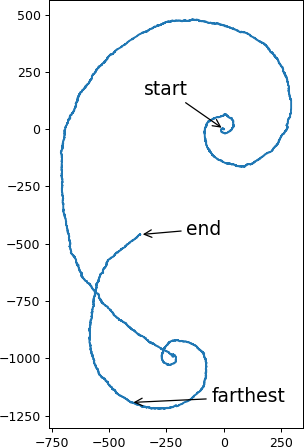

In [49]:
_ = day11(puzzle.input, visualize=True)

<a name="day12"></a>
## Day 12: Union-Find

- Part 1: How many programs are in the group that contains program ID 0?

- Part 2: How many groups are there in total?

In [50]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2017/day/12), `puzzle.input` has 2_000 lines:

0 <-> 396, 1867
1 <-> 1749
2 <-> 466, 675, 1661
3 <-> 3, 328, 1160
4 <-> 4, 953
5 <-> 1922
6 <-> 1273
7 <-> 7, 959
 ...
1996 <-> 844
1997 <-> 1682, 1894
1998 <-> 1351, 1769
1999 <-> 1374


The stored answers are: `{1: '283', 2: '195'}`

In [51]:
s1 = """\
0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5
"""

In [52]:
def day12(s, *, part2=False):
  union_find = hh.UnionFind[str]()
  nodes = []
  for line in s.splitlines():
    node1, rest = line.split(' <-> ')
    nodes.append(node1)
    for node2 in rest.split(', '):
      union_find.union(node1, node2)

  if not part2:
    num_in_group_of_0 = sum(union_find.same('0', node) for node in nodes)
    return num_in_group_of_0

  num_groups = len(set(union_find.find(node) for node in nodes))
  return num_groups


check_eq(day12(s1), 6)
puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
check_eq(day12_part2(s1), 2)
puzzle.verify(2, day12_part2)

(Part 1: 0.004 s)
(Part 2: 0.003 s)


<a name="day13"></a>
## Day 13: Layers of scanners

- Part 1: What is the severity of your whole trip?

- Part 2: What is the fewest number of picoseconds that you need to delay the packet to pass through the firewall without being caught?

In [53]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2017/day/13), `puzzle.input` has 43 lines:

0: 4
1: 2
2: 3
4: 5
6: 8
8: 4
10: 6
12: 6
 ...
80: 17
82: 28
84: 18
86: 14


The stored answers are: `{1: '1904', 2: '3833504'}`

In [54]:
s1 = """\
0: 3
1: 2
4: 4
6: 4
"""

In [55]:
def day13(s):  # Supports Part 1 only.
  range_of_depth = {}
  for line in s.splitlines():
    s1, s2 = line.split(': ')
    depth, range_ = int(s1), int(s2)
    assert depth >= 0 and range_ >= 2
    range_of_depth[depth] = range_

  max_depth = max(range_of_depth.keys())
  scanner_pos = {depth: 0 for depth in range_of_depth}
  scanner_inc = {depth: +1 for depth in range_of_depth}

  total_severity = 0
  for depth in range(max_depth + 1):
    if scanner_pos.get(depth) == 0:
      severity = depth * range_of_depth[depth]
      total_severity += severity
    for depth in scanner_pos:
      scanner_pos[depth] += scanner_inc[depth]
      if scanner_pos[depth] in (0, range_of_depth[depth] - 1):
        scanner_inc[depth] = -scanner_inc[depth]

  return total_severity


check_eq(day13(s1), 24)
puzzle.verify(1, day13)

(Part 1: 0.001 s)


In [56]:
def day13a_part2(s):  # Brute-force simplistic approach.
  range_of_depth = {}
  for line in s.splitlines():
    s1, s2 = line.split(': ')
    depth, range_ = int(s1), int(s2)
    range_of_depth[depth] = range_
  max_depth = max(range_of_depth.keys())
  scanner_pos0 = {depth: 0 for depth in range_of_depth}
  scanner_inc0 = {depth: +1 for depth in range_of_depth}

  for delay in itertools.count():
    scanner_pos = scanner_pos0.copy()
    scanner_inc = scanner_inc0.copy()

    ok = True
    for depth in range(max_depth + 1):
      if scanner_pos.get(depth) == 0:
        ok = False
        break
      for depth in scanner_pos:
        scanner_pos[depth] += scanner_inc[depth]
        if scanner_pos[depth] in (0, range_of_depth[depth] - 1):
          scanner_inc[depth] = -scanner_inc[depth]

    if ok:
      return delay

    for depth in scanner_pos0:
      scanner_pos0[depth] += scanner_inc0[depth]
      if scanner_pos0[depth] in (0, range_of_depth[depth] - 1):
        scanner_inc0[depth] = -scanner_inc0[depth]


check_eq(day13a_part2(s1), 10)
if 0:
  puzzle.verify(2, day13a_part2)  # ~56 s.

In [57]:
def day13b_part2(s):  # Use numpy but one delay at a time.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.splitlines()])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for delay in itertools.count():
    if np.all((delay + depth) % period):
      return delay


check_eq(day13b_part2(s1), 10)
if 0:
  puzzle.verify(2, day13b_part2)  # ~11 s.

In [58]:
def day13c_part2(s, *, chunk=3_000):  # Use numpy vectorized over chunks of delays.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.splitlines()])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for index in itertools.count():
    delay = np.arange(index * chunk, (index + 1) * chunk)
    matrix = (delay[:, None] + depth) % period
    (indices,) = np.nonzero(matrix.all(axis=1))
    if len(indices):
      return delay[0] + indices[0]


check_eq(day13c_part2(s1), 10)
puzzle.verify(2, day13c_part2)

(Part 2: 0.525 s)


In [59]:
def day13d_part2(s, *, chunk=80_000):  # Use numpy sieve; iterate on scanners over chunks of delays.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.splitlines()])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for index in itertools.count():
    delay = np.arange(index * chunk, (index + 1) * chunk)
    ok = np.full(chunk, True)
    for d, p in zip(depth, period):
      ok[(delay + d) % p == 0] = False
    (indices,) = np.nonzero(ok)
    if len(indices):
      return delay[0] + indices[0]


check_eq(day13d_part2(s1), 10)
puzzle.verify(2, day13d_part2)

(Part 2: 0.416 s)


In [60]:
def day13_part2(s, *, chunk=100_000):  # Use numpy sieve (~Eratosthenes) with array slices.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.splitlines()])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for start in itertools.count(0, chunk):
    ok = np.full(chunk, True)
    for d, p in zip(depth, period):
      first = (-(start + d)) % p
      ok[first:chunk:p] = False
    (indices,) = np.nonzero(ok)
    if len(indices):
      return start + indices[0]


check_eq(day13_part2(s1, chunk=4), 10)
puzzle.verify(2, day13_part2)

(Part 2: 0.005 s)


<a name="day14"></a>
## Day 14: Grid from knot hash

- Part 1: How many squares are used?

- Part 2: How many regions are present?

In [61]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2017/day/14), `puzzle.input` has a single line of 8 characters:

hwlqcszp


The stored answers are: `{1: '8304', 2: '1018'}`

In [62]:
def day14a(s, *, part2=False):  # Slower version.
  s = s.strip()

  def knot_hash(s: str, num: int = 256, num_rounds: int = 64) -> list[int]:
    lengths = [ord(ch) for ch in s] + [17, 31, 73, 47, 23]
    state = list(range(num))
    position = 0
    skip = 0
    for _ in range(num_rounds):
      for length in lengths:
        assert length <= num
        rotated = state[position:] + state[:position] if position else state
        rotated[:length] = reversed(rotated[:length])
        state = rotated[-position:] + rotated[:-position] if position else rotated
        position = (position + length + skip) % num
        skip += 1
    return [
        functools.reduce(operator.xor, group, 0)
        for group in more_itertools.chunked(state, 16, strict=True)
    ]

  shape = 128, 128
  grid = np.full(shape, 0)
  for row in range(shape[0]):
    values = knot_hash(f'{s}-{row}')
    bits = ''.join(f'{value:08b}' for value in values)
    grid[row] = np.array(list(bits)) == '1'

  if not part2:
    # hh.show(grid[:8, :8])
    return np.sum(grid)

  union_find = hh.UnionFind[Tuple[int, int]]()
  for y, x in np.argwhere(grid):
    for y2, x2 in ((y + 1, x), (y, x + 1)):
      if y2 < shape[0] and x2 < shape[1] and grid[y2, x2]:
        union_find.union((y, x), (y2, x2))

  return len(set(union_find.find((y, x)) for y, x in np.argwhere(grid)))


check_eq(day14a('flqrgnkx'), 8108)
puzzle.verify(1, day14a)

day14a_part2 = functools.partial(day14a, part2=True)
check_eq(day14a_part2('flqrgnkx'), 1242)
puzzle.verify(2, day14a_part2)

(Part 1: 0.284 s)
(Part 2: 0.297 s)


In [63]:
def day14(s, *, part2=False, visualize=False):  # Faster, without rotation or reversed().
  s = s.strip()

  def knot_hash(s: str, num: int = 256, num_rounds: int = 64) -> list[int]:
    lengths = [ord(ch) for ch in s] + [17, 31, 73, 47, 23]
    state = list(range(num))
    position = 0
    skip = 0
    for _ in range(num_rounds):
      for length in lengths:
        assert length <= num
        rear = num - position
        front = length - rear
        if front <= 0:
          state[position : position + length] = state[
              position + length - 1 : (position - 1 if position else None) : -1
          ]
        elif front <= rear:
          state[:front], state[position : position + front] = (
              state[position + front - 1 : (position - 1 if position else None) : -1],
              state[front - 1 :: -1],
          )
          state[position + front :] = state[-1 : position + front - 1 : -1]
        else:
          begin = front - rear
          state[position:], state[begin:front] = (
              state[front - 1 : (begin - 1 if begin else None) : -1],
              state[-1 : position - 1 : -1],
          )
          state[:begin] = state[begin - 1 :: -1]
        position = (position + length + skip) % num
        skip += 1
    return [
        functools.reduce(operator.xor, group, 0)
        for group in more_itertools.chunked(state, 16, strict=True)
    ]

  shape = 128, 128
  grid = np.full(shape, 0)
  for row in range(shape[0]):
    values = knot_hash(f'{s}-{row}')
    bits = ''.join(f'{value:08b}' for value in values)
    grid[row] = np.array(list(bits)) == '1'

  if not part2:
    if visualize:
      image = grid.repeat(2, axis=0).repeat(2, axis=1) == 0
      media.show_image(image, border=True, title='day14')
    return np.sum(grid)

  union_find = hh.UnionFind[Tuple[int, int]]()
  # for y, x in np.argwhere(grid):  # Slowest
  # for y, x in zip(*np.nonzero(grid)):  # Slow.
  # for y, x in np.ndindex(shape): if grid[y, x]:  # Only slightly slower.
  for y, x in (yx for yx, value in np.ndenumerate(grid) if value):  # Fastest.
    for y2, x2 in ((y + 1, x), (y, x + 1)):
      if y2 < shape[0] and x2 < shape[1] and grid[y2, x2]:
        union_find.union((y, x), (y2, x2))

  return len(set(union_find.find((y, x)) for (y, x), value in np.ndenumerate(grid) if value))


check_eq(day14('flqrgnkx'), 8108)
puzzle.verify(1, day14)

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2('flqrgnkx'), 1242)
puzzle.verify(2, day14_part2)

(Part 1: 0.066 s)
(Part 2: 0.080 s)


day14

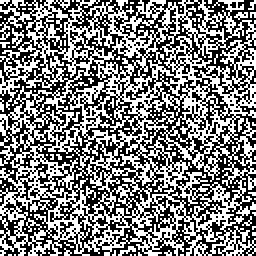

In [64]:
_ = day14(puzzle.input, visualize=True)

<a name="day15"></a>
## Day 15: Dueling generators

- Part 1: After 40 million pairs, what is the judge's final count?

- Part 2: After 5 million pairs, but using this new generator logic, what is the judge's final count?

In [65]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2017/day/15), `puzzle.input` has 2 lines:

Generator A starts with 634
Generator B starts with 301


The stored answers are: `{1: '573', 2: '294'}`

In [66]:
s1 = """\
Generator A starts with 65
Generator B starts with 8921
"""

In [67]:
@numba.njit
def day15_compute(state0: int, state1: int, part2: bool) -> int:
  factor0, factor1 = 16807, 48271
  num_matches = 0
  num_checks = 5_000_000 if part2 else 40_000_000
  for _ in range(num_checks):
    while True:
      state0 = (state0 * factor0) % 2147483647
      if not part2 or state0 & 3 == 0:
        break
    while True:
      state1 = (state1 * factor1) % 2147483647
      if not part2 or state1 & 7 == 0:
        break
    num_matches += (state0 & 65535) == (state1 & 65535)
  return num_matches


def day15(s, *, part2=False):
  state0, state1 = (int(line.split(' starts with ')[1]) for line in s.splitlines())
  return day15_compute(state0, state1, part2)


check_eq(day15(s1), 588)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
check_eq(day15_part2(s1), 309)
puzzle.verify(2, day15_part2)

(Part 1: 0.138 s)
(Part 2: 0.205 s)


<a name="day16"></a>
## Day 16: Permutation dance

- Part 1: In what order are the programs standing after their dance?

- Part 2: In what order are the programs standing after their billion dances?

In [68]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2017/day/16), `puzzle.input` has a single line of 48_521 characters:

x6/12,s14,x14/1,s5,x12/7,pn/i,x10/11,ph/p,x7/4,s7,x3/11,s4,pf/d,x13/12,s14,x1/8, ... ,pd/c,x5/11,s8,x3/0,po/l,x15/5,pp/d


The stored answers are: `{1: 'cgpfhdnambekjiol', 2: 'gjmiofcnaehpdlbk'}`

In [69]:
def day16a_part1(s, *, num=16):  # Simpler version supporting only Part 1.
  state = [chr(ord('a') + i) for i in range(num)]

  for move in s.strip().split(','):
    operation, operands = move[0], move[1:]
    match operation:
      case 's':
        size = int(operands)
        assert 1 <= size < num
        state = state[-size:] + state[:-size]
      case 'x':
        pos0, pos1 = (int(s2) for s2 in operands.split('/'))
        state[pos0], state[pos1] = state[pos1], state[pos0]
      case 'p':
        ch0, ch1 = operands.split('/')
        index0, index1 = state.index(ch0), state.index(ch1)
        state[index0], state[index1] = ch1, ch0
      case _:
        raise ValueError(move)

  return ''.join(state)


check_eq(day16a_part1('s1,x3/4,pe/b', num=5), 'baedc')
puzzle.verify(1, day16a_part1)  # e.g. 'olgejankfhbmpidc'

(Part 1: 0.005 s)


In [70]:
def day16(s, *, num=16, num_permutations=1):
  # We track two permutations: a permutation on symbols, and a permutation on positions.
  perm_sym = list(range(num))  # Destination sym for each source sym.
  perm_pos = list(range(num))  # Destination pos for each source pos.

  for move in s.strip().split(','):
    operation, operands = move[0], move[1:]
    match operation:
      case 'p':
        sym0, sym1 = (ord(ch) - ord('a') for ch in operands.split('/'))
        index0, index1 = perm_sym.index(sym0), perm_sym.index(sym1)
        perm_sym[index0], perm_sym[index1] = sym1, sym0
      case 's':
        size = int(operands)
        assert 1 <= size < num
        for i, pos in enumerate(perm_pos):
          perm_pos[i] = pos + (size if pos < num - size else size - num)
      case 'x':
        pos0, pos1 = (int(s2) for s2 in operands.split('/'))
        index0, index1 = perm_pos.index(pos0), perm_pos.index(pos1)
        perm_pos[index0], perm_pos[index1] = pos1, pos0
      case _:
        raise ValueError(move)

  def evaluate(perm_sym: list[int], perm_pos: list[int]) -> str:
    # Invert permutation using https://stackoverflow.com/a/11649931.
    return ''.join(chr(perm_sym[i] + ord('a')) for i in np.argsort(perm_pos))

  @functools.cache
  def compose(num_permutations: int) -> tuple[list[int], list[int]]:
    if num_permutations == 1:
      return perm_sym, perm_pos
    num0, num1 = (num_permutations + 1) // 2, num_permutations // 2
    (perm_sym0, perm_pos0), (perm_sym1, perm_pos1) = compose(num0), compose(num1)
    return ([perm_sym1[sym0] for sym0 in perm_sym0], [perm_pos1[pos0] for pos0 in perm_pos0])

  return evaluate(*compose(num_permutations))


check_eq(day16('s1,x3/4,pe/b', num=5), 'baedc')
puzzle.verify(1, day16)  # e.g. 'olgejankfhbmpidc'

day16_part2 = functools.partial(day16, num_permutations=1_000_000_000)
check_eq(day16_part2('s1,x3/4,pe/b', num=5, num_permutations=2), 'ceadb')
puzzle.verify(2, day16_part2)

(Part 1: 0.009 s)
(Part 2: 0.009 s)


<a name="day17"></a>
## Day 17: Circular buffer

- Part 1: What is the value after 2017 in your completed circular buffer?

- Part 2: What is the value after 0 the moment 50000000 is inserted?

In [71]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2017/day/17), `puzzle.input` has a single line of 3 characters:

366


The stored answers are: `{1: '1025', 2: '37803463'}`

In [72]:
@numba.njit  # ~2.6 s -> ~0.16 s.
def day17_compute_part2(step: int) -> int:
  pos = -1
  after_zero = -1
  step1 = step + 1

  for index in range(1, 50_000_000 + 1):
    pos = (pos + step1) % index
    if pos == 0:
      after_zero = index

  return after_zero
  # Comparable to C++:
  # https://ideone.com/HLrQCx  0.4 s.
  # https://www.online-cpp.com/rluemsc5ha  1.2 s.


def day17(s, *, part2=False):
  step = int(s)
  assert step > 0

  if not part2:
    pos = 0
    state = [0]

    for index in range(2017):
      pos = (pos + step) % len(state)
      state = state[: pos + 1] + [index + 1] + state[pos + 1 :]
      pos = pos + 1

    return state[pos + 1]

  return day17_compute_part2(step)


check_eq(day17('3'), 638)
puzzle.verify(1, day17)

day17_part2 = functools.partial(day17, part2=True)
_ = day17_part2(puzzle.input)  # For numba jit.
puzzle.verify(2, day17_part2)

(Part 1: 0.006 s)
(Part 2: 0.153 s)


<a name="day18"></a>
## Day 18: Two async programs

- Part 1: What is the value of the recovered frequency (the value of the most recently played sound) the first time a rcv instruction is executed with a non-zero value?

- Part 2: Once both of your programs have terminated (regardless of what caused them to do so), how many times did program 1 send a value?

In [73]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2017/day/18), `puzzle.input` has 41 lines:

set i 31
set a 1
mul p 17
jgz p p
mul a 2
add i -1
jgz i -2
add a -1
 ...
jgz i -11
snd a
jgz f -16
jgz a -19


The stored answers are: `{1: '4601', 2: '6858'}`

In [74]:
s1 = """\
set a 1
add a 2
mul a a
mod a 5
snd a
set a 0
rcv a
jgz a -1
set a 1
jgz a -2
"""

In [75]:
s2 = """\
snd 1
snd 2
snd p
rcv a
rcv b
rcv c
rcv d
"""

In [76]:
def day18(s):
  instructions = [tuple(line.split(' ')) for line in s.splitlines()]
  pc = 0
  registers: collections.defaultdict[str, int] = collections.defaultdict(int)
  sound: int | None = None

  def get(value: str) -> int:
    return registers[value] if value.isalpha() else int(value)

  while True:
    assert 0 <= pc < len(instructions)
    match instructions[pc]:
      case 'snd', operand:
        sound = get(operand)
      case 'rcv', operand:
        if get(operand) != 0:
          return sound
      case 'set', dst, src:
        registers[dst] = get(src)
      case 'add', dst, src:
        registers[dst] += get(src)
      case 'mul', dst, src:
        registers[dst] *= get(src)
      case 'mod', dst, src:
        registers[dst] %= get(src)
      case 'jgz', predicate, offset:
        if get(predicate) > 0:
          pc += get(offset) - 1
      case x:
        raise ValueError(x)
    pc += 1


check_eq(day18(s1), 4)
puzzle.verify(1, day18)

(Part 1: 0.001 s)


In [77]:
def day18_part2(s):
  instructions = [tuple(line.split(' ')) for line in s.splitlines()]
  evaluate = {
      'set': lambda _, b: b,
      'add': lambda a, b: a + b,
      'mul': lambda a, b: a * b,
      'mod': lambda a, b: a % b,
  }

  @dataclasses.dataclass
  class Program:
    """One of two programs running the shared `instructions`."""

    program_id: int
    pc: int = 0
    registers: collections.defaultdict[str, int] = dataclasses.field(
        default_factory=lambda: collections.defaultdict(int)
    )
    queue: collections.deque[int] = dataclasses.field(default_factory=collections.deque)
    total_sends: int = 0

    def __post_init__(self):
      self.registers['p'] = self.program_id

    def get(self, value: str) -> int:
      return self.registers[value] if value.isalpha() else int(value)

    def execute(self) -> bool:
      if not 0 <= self.pc < len(instructions):
        return False
      match instructions[self.pc]:
        case 'snd', operand:
          other_program = programs[1 - self.program_id]
          other_program.queue.append(self.get(operand))
          self.total_sends += 1
        case 'rcv', operand:
          if not self.queue:
            return False
          self.registers[operand] = self.queue.popleft()
        case 'jgz', predicate, offset:
          if self.get(predicate) > 0:
            self.pc += self.get(offset) - 1
        case operation, dst, src:
          self.registers[dst] = evaluate[operation](self.registers[dst], self.get(src))
        case x:
          raise ValueError(x)
      self.pc += 1
      return True

  programs = [Program(0), Program(1)]
  while programs[0].execute() or programs[1].execute():
    pass
  return programs[1].total_sends


check_eq(day18_part2(s2), 3)
puzzle.verify(2, day18_part2)

(Part 2: 0.084 s)


<a name="day19"></a>
## Day 19: Follow 2D paths

- Part 1: What are the letters along the path?

- Part 2: How many steps does the packet need to go?

In [78]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2017/day/19), `puzzle.input` has 201 lines:

                                                                                 ...                  |                 
     +-------------------------------------------------------------------------- ... -----------------|-------------+   
     |                                                                           ...                  |             |   
     |               +-+   +-------+     +-------------------------------------- ...            +---+ |     +-+ +---|-+ 
     |               | |   |       |     |                                       ...            |   | |     | | |   | | 
   +-|-+             | |   |       |     +-------------------------------------- ...            |   +-|---------|-+ | | 
   | | |             | |   |       |                                             ...            |     |     | | | | | | 
 +-+ | |     +---------------------|-------------------------------------------- ... -----------|-----|-----+ | | | | | 
 ...
 +-|-----------------------

The stored answers are: `{1: 'GEPYAWTMLK', 2: '17628'}`

In [79]:
s1 = """\
     |          X
     |  +--+    X
     A  |  C    X
 F---|----E|--+ X
     |  |  |  D X
     +B-+  +--+ X
""".replace(
    'X', ''
)

In [80]:
def day19(s, *, part2=False):
  grid = hh.grid_from_string(s)  # shape=(201, 201).
  grid = np.pad(grid, ((0, 1), (0, 1)), constant_values=' ')
  # (y,), (x,) = np.nonzero(grid[:1] == '|')
  ((y, x),) = np.argwhere(grid[:1] == '|')
  dy, dx = 1, 0
  letters: list[str] = []
  num_steps = 0

  while True:
    num_steps += 1
    y, x = y + dy, x + dx
    match grid[y, x]:
      case '+':
        dy, dx = dx, dy  # One of the two 90-degree rotations.
        if grid[y + dy, x + dx] == ' ':
          dy, dx = -dy, -dx  # The other possible 90-degree rotation.
        if grid[y + dy, x + dx] == ' ':
          raise ValueError
      case ' ':
        return num_steps if part2 else ''.join(letters)
      case '|' | '-':
        pass
      case ch:
        assert ch.isalpha()
        letters.append(ch)


check_eq(day19(s1), 'ABCDEF')
puzzle.verify(1, day19)

day19_part2 = functools.partial(day19, part2=True)
check_eq(day19_part2(s1), 38)
puzzle.verify(2, day19_part2)

(Part 1: 0.009 s)
(Part 2: 0.010 s)


day19

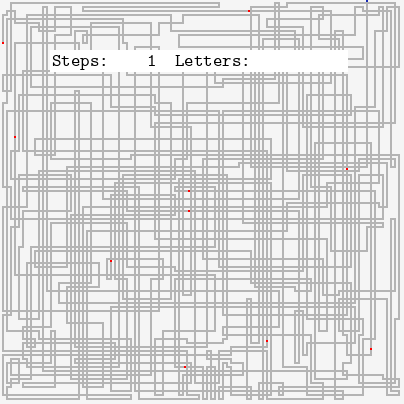

In [81]:
def day19_visualize(s):
  grid = hh.grid_from_string(s)  # shape=(201, 201).
  grid = np.pad(grid, ((0, 1), (0, 1)), constant_values=' ')
  ((y, x),) = np.argwhere(grid[:1] == '|')
  dy, dx = 1, 0
  letters = []
  num_steps = 0
  images = []
  image = hh.to_image((grid == '|') | (grid == '-') | (grid == '+'), 245, 180)
  image[np.char.isalpha(grid)] = 255, 0, 0

  while (ch := grid[y, x]) != ' ':
    ch = grid[y, x]
    if ch.isalpha():
      letters.append(ch)
    elif ch == '+':
      dy, dx = dx, dy  # One of the two 90-degree rotations.
      if grid[y + dy, x + dx] == ' ':
        dy, dx = -dy, -dx  # The other possible 90-degree rotation.
    image[y, x] = (255, 0, 0) if ch.isalpha() else (20, 40, 180)
    y, x = y + dy, x + dx
    if num_steps % 47 == 0 or grid[y, x] == ' ':
      image2 = image.repeat(2, axis=0).repeat(2, axis=1)
      text = f'Steps:{num_steps + 1:5}  Letters:{"".join(letters):10}'
      hh.overlay_text(image2, (50, 50), text, fontsize=18, align='tl', margin=((5, 2), (2, 2)))
      images.append(image2)
    num_steps += 1

  images = [images[0]] * 60 + images + [images[-1]] * 80
  media.show_video(images, codec='gif', fps=50, title='day19')


day19_visualize(puzzle.input)

<a name="day20"></a>
## Day 20: Accelerating 3D particles

- Part 1: Which particle will stay closest to position <0,0,0> in the long term?

- Part 2: How many particles are left after all collisions are resolved?

In [82]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2017/day/20), `puzzle.input` has 1_000 lines:

p=<-1724,-1700,5620>, v=<44,-10,-107>, a=<2,6,-9>
p=<551,3425,4570>, v=<-21,-7,-182>, a=<0,-10,0>
p=<-524,-3400,2495>, v=<22,19,5>, a=<0,9,-8>
p=<-123,-125,419>, v=<25,54,-12>, a=<-2,-5,-2>
p=<-3811,3483,1459>, v=<162,-112,-26>, a=<9,-12,-8>
p=<-827,475,771>, v=<52,-26,0>, a=<0,0,-6>
p=<293,1547,-669>, v=<-18,-93,-12>, a=<0,0,6>
p=<-251,-165,2787>, v=<16,-3,-160>, a=<0,2,-2>
 ...
p=<-1317,-1290,-1820>, v=<-189,-180,-258>, a=<11,12,24>
p=<2382,-652,1487>, v=<343,-96,213>, a=<-23,3,-10>
p=<-265,-2330,-2153>, v=<-32,-334,-305>, a=<1,20,18>
p=<995,1767,1881>, v=<141,252,264>, a=<-9,-12,-14>


The stored answers are: `{1: '150', 2: '657'}`

In [83]:
s1 = """\
p=< 3,0,0>, v=< 2,0,0>, a=<-1,0,0>
p=< 4,0,0>, v=< 0,0,0>, a=<-2,0,0>
"""

In [84]:
s2 = """\
p=<-6,0,0>, v=< 3,0,0>, a=< 0,0,0>
p=<-4,0,0>, v=< 2,0,0>, a=< 0,0,0>
p=<-2,0,0>, v=< 1,0,0>, a=< 0,0,0>
p=< 3,0,0>, v=<-1,0,0>, a=< 0,0,0>
"""

In [85]:
def day20(s, *, part2=False):
  lines = s.splitlines()

  def parse(ch: str) -> np.ndarray:
    pattern = ch + r'=<([0-9 -]+),([0-9 -]+),([0-9 -]+)>'
    return np.array([hh.re_groups(pattern, line) for line in lines], int)

  position, velocity, acceleration = (parse(ch) for ch in 'pva')

  if not part2:
    time = 1_000_000
    position = position + velocity * time + acceleration * (time * (time + 1) // 2)
    return np.abs(position).sum(axis=1).argmin()

  for time in range(200):
    velocity += acceleration
    position += velocity
    unused_unique, index, counts = np.unique(
        position, axis=0, return_index=True, return_counts=True
    )
    index = index[counts == 1]  # Indices of non-intersecting particles.
    position, velocity, acceleration = position[index], velocity[index], acceleration[index]

  return len(position)


check_eq(day20(s1), 0)
puzzle.verify(1, day20)

day20_part2 = functools.partial(day20, part2=True)
check_eq(day20_part2(s2), 1)
puzzle.verify(2, day20_part2)

(Part 1: 0.003 s)
(Part 2: 0.034 s)


<a name="day21"></a>
## Day 21: Super-resolution using rules

- Part 1: How many pixels stay on after 5 iterations?

- Part 2: How many pixels stay on after 18 iterations?

In [86]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2017/day/21), `puzzle.input` has 108 lines:

../.. => ###/###/.##
#./.. => ..#/###/##.
##/.. => ..#/##./##.
.#/#. => #../.#./.##
##/#. => #.#/###/.#.
##/## => ##./.../.#.
.../.../... => ...#/.#../#.#./##.#
#../.../... => .#.#/.#../####/###.
 ...
#.#/###/#.# => ..#./####/.#../##.#
###/###/#.# => ..../.#.#/..../...#
###/#.#/### => #.#./..##/##.#/....
###/###/### => ..#./#.##/####/###.


The stored answers are: `{1: '208', 2: '2480380'}`

In [87]:
s1 = """\
../.# => ##./#../...
.#./..#/### => #..#/..../..../#..#
"""

In [88]:
def day21(s, *, num_iterations=5, visualize=False):
  def get_grid(s: str) -> np.ndarray:
    return (np.array([list(row) for row in s.split('/')]) == '#').astype(int)

  rules = {2: np.full((2**4, 3, 3), 0), 3: np.full((2**9, 4, 4), 0)}
  for line in s.splitlines():
    grid_lhs, grid_rhs = map(get_grid, line.split(' => '))
    size = grid_lhs.shape[0]
    for _ in range(2):
      grid_lhs = np.fliplr(grid_lhs)
      for _ in range(4):
        grid_lhs = np.rot90(grid_lhs)
        encoded = grid_lhs.reshape(-1).dot(2 ** np.arange(size**2))
        rules[size][encoded] = grid_rhs

  grid = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]])

  grids = []
  for index in range(num_iterations):
    if visualize and index < 13:
      grids.append(grid == 0)
    n = grid.shape[0]
    size = 2 if n % 2 == 0 else 3
    new_size = {2: 3, 3: 4}[size]
    m = n // size
    new_n = m * new_size
    grid_blocks = grid.reshape((m, size, m, size)).transpose(0, 2, 1, 3).reshape((m, m, size**2))
    encoded = grid_blocks.dot(2 ** np.arange(size**2))
    new_blocks = rules[size][encoded]
    grid = new_blocks.transpose(0, 2, 1, 3).reshape(new_n, new_n)

  if visualize:
    combined = hh.assemble_arrays(grids, (1, -1), background=True, spacing=8)
    combined = np.pad(combined, 4, constant_values=True)
    media.show_image(combined, border=True, title='day21')

  return np.sum(grid)


check_eq(day21(s1, num_iterations=2), 12)
puzzle.verify(1, day21)

day21_part2 = functools.partial(day21, num_iterations=18)  # grid.shape = (2187, 2187)
puzzle.verify(2, day21_part2)

(Part 1: 0.010 s)
(Part 2: 0.082 s)


day21

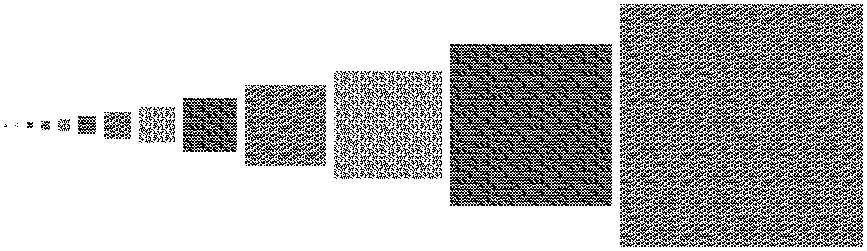

In [89]:
_ = day21_part2(puzzle.input, visualize=True)

<a name="day22"></a>
## Day 22: Turtle graphics automaton

- Part 1: Given your actual map, after 10000 bursts of activity, how many bursts cause a node to become infected? (Do not count nodes that begin infected.)

- Part 2: With the addition of Weakened and Flagged, after 10000000 bursts of activity, how many bursts cause a node to become infected?

In [90]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2017/day/22), `puzzle.input` has 25 lines:

...#.##.#.#.#.#..##.###.#
......##.....#####..#.#.#
#..####.######.#.#.##...#
...##..####........#.#.#.
.#.#####..#.....#######..
.#...#.#.##.#.#.....#....
.#.#.#.#.#####.#.#..#...#
###..##.###.#.....#...#.#
 ...
##.##..####..##.##.##.##.
#...####.######.#...##...
.###..##.##..##.####....#
#.##....#.#.#..#.###..##.


The stored answers are: `{1: '5406', 2: '2511640'}`

In [91]:
s1 = """\
..#
#..
...
"""

In [92]:
def day22a(s, *, num_iterations=10_000, part2=False, visualize=False):
  initial_grid = hh.grid_from_string(s)
  cy, cx = np.array(initial_grid.shape) // 2
  grid = {(y - cy, x - cx): '#' for y, x in np.argwhere(initial_grid == '#')}
  y, x = 0, 0
  dy, dx = -1, 0  # Up direction.
  num_newly_infected = 0
  UPDATE = {' ': 'W', 'W': '#', '#': 'F', 'F': ' '} if part2 else {' ': '#', '#': ' '}
  cmap = {' ': (235, 235, 235), '#': (255, 0, 0), 'W': (50, 50, 200), 'F': (0, 150, 0)}

  for _ in range(num_iterations):
    state = grid.get((y, x), ' ')
    match state:
      case ' ':
        dy, dx = -dx, dy  # Turn left.
      case '#':
        dy, dx = dx, -dy  # Turn right.
      case 'F':
        dy, dx = -dy, -dx  # Make U-turn.
    grid[y, x] = new_state = UPDATE[state]
    num_newly_infected += new_state == '#'
    y, x = y + dy, x + dx

  if visualize:
    # hh.show(max(abs(x) + abs(y) for y, x in grid))  # 335
    image = hh.image_from_yx_map(grid, background=' ', cmap=cmap)
    media.show_image(image, title='day22')

  return num_newly_infected


check_eq(day22a(s1, num_iterations=7), 5)
check_eq(day22a(s1, num_iterations=70), 41)
check_eq(day22a(s1), 5587)
puzzle.verify(1, day22a)

day22a_part2 = functools.partial(day22a, num_iterations=10_000_000, part2=True)
check_eq(day22a_part2(s1, num_iterations=100), 26)
# check_eq(day22a_part2(s1), 2_511_944)
# puzzle.verify(2, day22a_part2)  # ~2.2 s.

(Part 1: 0.004 s)


day22

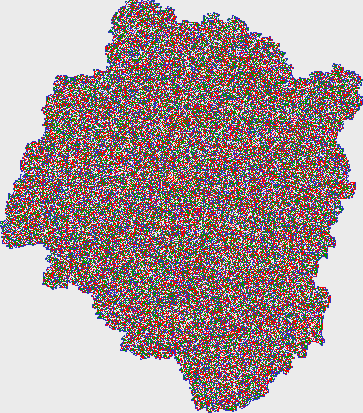

In [93]:
_ = day22a_part2(puzzle.input, visualize=True)

In [94]:
@numba.njit  # ~3.9 s -> ~0.05 s.
def day22_compute(grid: np.ndarray, num_iterations: int, update: tuple[int, ...]) -> int:
  y, x = grid.shape[0] // 2, grid.shape[1] // 2
  dy, dx = -1, 0  # Up direction.
  num_newly_infected = 0
  for _ in range(num_iterations):
    state = grid[y, x]
    match state:
      case 0:
        dy, dx = -dx, dy  # Turn left.
      case 1:
        dy, dx = dx, -dy  # Turn right.
      case 3:
        dy, dx = -dy, -dx  # Make U-turn.
    grid[y, x] = new_state = update[state]
    num_newly_infected += new_state == 1
    y, x = y + dy, x + dx
  return num_newly_infected


def day22(s, *, num_iterations=10_000, part2=False):
  grid = hh.grid_from_string(s, {'.': 0, '#': 1})  # Later also: {'W': 2, 'F': 3}.
  pad = 500 if part2 else 200
  grid = np.pad(grid, pad)
  update = (2, 3, 1, 0) if part2 else (1, 0)
  return day22_compute(grid, num_iterations, update)


check_eq(day22(s1, num_iterations=7), 5)
check_eq(day22(s1, num_iterations=70), 41)
check_eq(day22(s1), 5587)
puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, num_iterations=10_000_000, part2=True)
check_eq(day22_part2(s1, num_iterations=100), 26)
check_eq(day22_part2(s1), 2_511_944)
puzzle.verify(2, day22_part2)

(Part 1: 0.000 s)
(Part 2: 0.052 s)


<a name="day23"></a>
## Day 23: Reverse-engineer program

- Part 1: If you run the program (your puzzle input), how many times is the mul instruction invoked?

- Part 2: After setting register a to 1, if the program were to run to completion, what value would be left in register h?

In [95]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2017/day/23), `puzzle.input` has 32 lines:

set b 84
set c b
jnz a 2
jnz 1 5
mul b 100
sub b -100000
set c b
sub c -17000
 ...
jnz g 2
jnz 1 3
sub b -17
jnz 1 -23


The stored answers are: `{1: '6724', 2: '903'}`

In [96]:
def day23(s, *, part2=False):
  instructions = [tuple(line.split(' ')) for line in s.splitlines()]
  pc = 0
  registers = collections.defaultdict(int)
  num_mul = 0
  registers['a'] = 1 if part2 else 0

  def get(value: str) -> int:
    return registers[value] if value.isalpha() else int(value)

  def is_prime(n: int) -> bool:
    return n > 1 and all(n % i != 0 for i in range(2, math.isqrt(n) + 1))

  while 0 <= pc < len(instructions):
    # hh.show(pc, instructions[pc])
    if part2 and pc == 8:
      # Big optimization: directly compute the number of non-primes in range(b, c + 1, 17).
      result = sum(not is_prime(i) for i in range(get('b'), get('c') + 1, 17))
      return result
    match instructions[pc]:
      case 'set', dst, src:
        registers[dst] = get(src)
      case 'sub', dst, src:
        registers[dst] -= get(src)
      case 'mul', dst, src:
        registers[dst] *= get(src)
        num_mul += 1
      case 'jnz', predicate, offset:
        if get(predicate) != 0:
          pc += get(offset) - 1
      case x:
        raise ValueError(x)
    pc += 1

  return num_mul


puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
puzzle.verify(2, day23_part2)

(Part 1: 0.014 s)
(Part 2: 0.002 s)


In [97]:
# print('\n'.join(f'# L{i:02} {line:14} # ' for i, line in enumerate(puzzle.input.splitlines())))

# L00 set b 84|93    # b = 84|93
# L01 set c b        # c = b
# L02 jnz a 2        # if a != 0: jmp L04
# L03 jnz 1 5        # jmp L08

# L04 mul b 100      # b *= 100
# L05 sub b -100000  # b += 100_000
# L06 set c b        # c = b
# L07 sub c -17000   # c += 17_000

# L08 set f 1        # f = 1
# L09 set d 2        # d = 2

# L10 set e 2        # e = 2

# L11 set g d        # g = d
# L12 mul g e        # g *= e
# L13 sub g b        # g -= b
# L14 jnz g 2        # if g != 0: goto L16
# L15 set f 0        # f = 0

# L16 sub e -1       # e += 1
# L17 set g e        # g = e
# L18 sub g b        # g -= b
# L19 jnz g -8       # if g != 0: goto L11
# L20 sub d -1       # d += 1
# L21 set g d        # g = d
# L22 sub g b        # g -= b
# L23 jnz g -13      # if g != 0: goto L10
# L24 jnz f 2        # if f != 0: goto L26
# L25 sub h -1       # h += 1

# L26 set g b        # g = b
# L27 sub g c        # g -= c
# L28 jnz g 2        # if g != 0: goto L30
# L29 jnz 1 3        # exit

# L30 sub b -17      # b += 17
# L31 jnz 1 -23      # goto L08

In [98]:
# L00 set b 93       #
# L01 set c b        #
# L04 mul b 100      #
# L05 sub b -100000  # b = 109_300
# L06 set c b        #
# L07 sub c -17000   # c = 126_300

# With a=0: b=93 c=93 num=1
# With a=1: b=109_300 c=126_301 num=1000

#                    # for b in range(b, c + 1, 17):
# L08 set f 1        #   f = 1
# L09 set d 2        #   d = 2

# L10 set e 2        #   for e in range(2, b + 1):
# L11 set g d        #
# L12 mul g e        #
# L13 sub g b        #
# L14 jnz g 2        #     if d * e == b: f = 0   # if b % d == 0: f = 0
# L15 set f 0        #
# L16 sub e -1       #
# L17 set g e        #
# L18 sub g b        #
# L19 jnz g -8       #
# L20 sub d -1       #   d += 1
# L21 set g d        #
# L22 sub g b        #
# L23 jnz g -13      #   if d != b: goto L10
# L24 jnz f 2        #   if f == 0:
# L25 sub h -1       #     h += 1
# L26 set g b        #
# L27 sub g c        #
# L28 jnz g 2        #
# L30 sub b -17      #
# L31 jnz 1 -23      #

In [99]:
# for b in range(b, c + 1, 17):
#   f = 1
#
#   for d in range(2, b + 1):
#     if b % d == 0: f = 0
#
#   if f == 0:
#     h += 1

<a name="day24"></a>
## Day 24: Long domino chains

- Part 1: What is the strength of the strongest bridge you can make with the components you have available?

- Part 2: Of all bridges of the longest possible length, what is the strength of the strongest one?

In [100]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2017/day/24), `puzzle.input` has 57 lines:

24/14
30/24
29/44
47/37
6/14
20/37
14/45
5/5
 ...
2/17
46/17
29/29
45/50


The stored answers are: `{1: '2006', 2: '1994'}`

In [101]:
s1 = """\
0/2
2/2
2/3
3/4
3/5
0/1
10/1
9/10
"""

In [102]:
def day24a(s, *, start=0, part2=False):  # Slower, creating list of updated remaining components.
  components: list[tuple[int, int]] = [
      tuple(map(int, line.split('/'))) for line in s.splitlines()  # type: ignore[misc]
  ]
  check_eq(len(components), len(set(components)))  # In fact, they are all unique.

  def compatible_components(start: int, components: list[tuple[int, int]]):
    for i, (v0, v1) in enumerate(components):
      if v1 == start:
        v1 = v0
      elif v0 != start:
        continue
      remaining = components[:i] + components[i + 1 :]
      yield v1, remaining

  def compute_strongest(v0: int, components: list[tuple[int, int]]) -> int:
    max_strength = 0
    for v1, remaining in compatible_components(v0, components):
      max_strength = max(max_strength, v0 + v1 + compute_strongest(v1, remaining))
    return max_strength

  if not part2:
    return compute_strongest(start, components)

  def compute_longest_length(v0: int, components: list[tuple[int, int]]) -> int:
    max_length = 0
    for v1, remaining in compatible_components(v0, components):
      max_length = max(max_length, 1 + compute_longest_length(v1, remaining))
    return max_length

  def compute_longest(v0: int, remaining_length: int, components: list[tuple[int, int]]) -> int:
    max_strength = 0 if remaining_length == 0 else -10_000
    for v1, remaining in compatible_components(v0, components):
      max_strength = max(
          max_strength, v0 + v1 + compute_longest(v1, remaining_length - 1, remaining)
      )
    return max_strength

  longest_length = compute_longest_length(start, components)
  return compute_longest(start, longest_length, components)


check_eq(day24a(s1), 31)
puzzle.verify(1, day24a)

day24a_part2 = functools.partial(day24a, part2=True)
check_eq(day24a_part2(s1), 19)
if 0:
  puzzle.verify(2, day24a_part2)  # ~1.8 s.

(Part 1: 0.906 s)


In [103]:
def day24b(s, *, start=0, part2=False):  # Faster; side effects on sets of remaining components.
  components = [tuple(map(int, line.split('/'))) for line in s.splitlines()]
  max_v = max(max(v0, v1) for v0, v1 in components)
  active_from_v: list[set[int]] = [set() for v in range(max_v + 1)]
  for v0, v1 in components:
    active_from_v[v0].add(v1)
    if v1 != v0:
      active_from_v[v1].add(v0)

  def compatible_components(v0: int) -> Iterator[int]:
    set_v0 = active_from_v[v0]
    for v1 in list(set_v0):
      if v1 != v0:
        set_v1 = active_from_v[v1]
        set_v0.remove(v1)
        set_v1.remove(v0)
        yield v1
        set_v1.add(v0)
        set_v0.add(v1)
      else:
        set_v0.remove(v1)
        yield v1
        set_v0.add(v1)

  def compute_strongest(v0: int) -> int:
    max_strength = 0
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_strongest(v1))
    return max_strength

  if not part2:
    return compute_strongest(start)

  def compute_longest_length(v0: int) -> int:
    max_length = 0
    for v1 in compatible_components(v0):
      max_length = max(max_length, 1 + compute_longest_length(v1))
    return max_length

  def compute_longest(v0: int, remaining_length: int) -> int:
    max_strength = 0 if remaining_length == 0 else -10_000
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_longest(v1, remaining_length - 1))
    return max_strength

  longest_length = compute_longest_length(start)  # 36
  return compute_longest(start, longest_length)


check_eq(day24b(s1), 31)
puzzle.verify(1, day24b)

day24b_part2 = functools.partial(day24b, part2=True)
check_eq(day24b_part2(s1), 19)
puzzle.verify(2, day24b_part2)

(Part 1: 0.239 s)
(Part 2: 0.480 s)


In [104]:
# Immediately treat (v0, v0) pairs, and canonicalize order of loops.
def day24(s, *, start=0, part2=False):
  components = [tuple(map(int, line.split('/'))) for line in s.splitlines()]
  max_v = max(max(v0, v1) for v0, v1 in components)
  has_pair = [False] * (max_v + 1)
  active_from_v: list[set[int]] = [set() for v in range(max_v + 1)]
  for v0, v1 in components:
    if v0 == v1:
      has_pair[v0] = True
    else:
      active_from_v[v0].add(v1)
      active_from_v[v1].add(v0)

  def compatible_components(v0: int) -> Iterator[int]:
    if has_pair[v0]:
      has_pair[v0] = False
      yield v0
      has_pair[v0] = True
    else:
      set_v0 = active_from_v[v0]
      candidates = list(set_v0)  # Not even sorted().
      for v1 in candidates:
        set_v0.remove(v1)
        active_from_v[v1] -= {v0}
        yield v1
        set_v0.add(v1)
      for v1 in candidates:
        active_from_v[v1].add(v0)

  def compute_strongest(v0: int) -> int:
    max_strength = 0
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_strongest(v1))
    return max_strength

  if not part2:
    return compute_strongest(start)

  def compute_longest_length(v0: int) -> int:
    max_length = 0
    for v1 in compatible_components(v0):
      max_length = max(max_length, 1 + compute_longest_length(v1))
    return max_length

  def compute_longest(v0: int, remaining_length: int) -> int:
    max_strength = 0 if remaining_length == 0 else -10_000
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_longest(v1, remaining_length - 1))
    return max_strength

  longest_length = compute_longest_length(start)  # 36
  return compute_longest(start, longest_length)


check_eq(day24(s1), 31)
puzzle.verify(1, day24)

day24_part2 = functools.partial(day24, part2=True)
check_eq(day24_part2(s1), 19)
puzzle.verify(2, day24_part2)

(Part 1: 0.099 s)
(Part 2: 0.199 s)


<a name="day25"></a>
## Day 25: Turing machine

- Part 1: After the specified number of steps have been executed, count the number of times 1 appears on the tape.

- Part 2: None on day 25.

In [105]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2017/day/25), `puzzle.input` has 62 lines:

Begin in state A.
Perform a diagnostic checksum after 12629077 steps.

In state A:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state B.
 ...
  If the current value is 1:
    - Write the value 1.
    - Move one slot to the left.
    - Continue with state E.


The stored answers are: `{1: '3745', 2: ''}`

In [106]:
s1 = """\
Begin in state A.
Perform a diagnostic checksum after 6 steps.

In state A:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state B.
  If the current value is 1:
    - Write the value 0.
    - Move one slot to the left.
    - Continue with state B.

In state B:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the left.
    - Continue with state A.
  If the current value is 1:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state A.
"""

In [107]:
def day25a(s):  # Slow version using dicts and Python.
  parts = s.split('\n\n')
  state, s_steps = hh.re_groups(r'^(?s)Begin in state (.+)\..* after (.+) steps', parts[0])
  num_steps = int(s_steps)
  logic = {}
  for part in parts[1:]:
    (current,) = hh.re_groups(r'^In state (.+):', part)
    conditions = part.split('If the current ')[1:]
    assert len(conditions) == 2
    for condition in conditions:
      pattern = r'^(?s)value is (.+):.*Write the value (.+)\..*to the (.+)\..* state (.+)\.'
      condition_state, s_write_value, s_move, next_state = hh.re_groups(pattern, condition)
      t = int(s_write_value), {'left': -1, 'right': +1}[s_move], next_state
      logic[current, int(condition_state)] = t

  tape: collections.defaultdict[int, int] = collections.defaultdict(int)
  pos = 0
  for _ in range(num_steps):
    write_value, move, state = logic[state, tape[pos]]
    tape[pos] = write_value
    pos += move

  # hh.Stats(record_pos) = ( 12_208_951)        -6960 : 28           av=-3000.24     sd=3422.89
  return sum(tape.values())


check_eq(day25a(s1), 3)
puzzle.verify(1, day25a)

(Part 1: 1.219 s)


In [108]:
# Fast version using integer arrays and jitted numba.
@numba.njit  # ~10.5 s -> 0.05 s.
def day25_compute(size: int, num_steps: int, state: int, logic: np.ndarray) -> int:
  tape = np.full(size, 0)
  pos = size // 2
  for _ in range(num_steps):
    write_value, move, state = logic[state * 2 + tape[pos]]
    tape[pos] = write_value
    pos += move
  return np.sum(tape)


def day25(s, *, size=100_000):
  parts = s.split('\n\n')
  s_state, s_steps = hh.re_groups(r'^(?s)Begin in state (.+)\..* after (.+) steps', parts[0])
  state, num_steps = ord(s_state) - ord('A'), int(s_steps)

  logic_lines: list[tuple[int, int, int]] = []  # (write_value, move, next_state)
  for part in parts[1:]:
    for condition in part.split('If the current ')[1:]:
      pattern = r'(?s)Write the value (.+)\..*to the (.+)\..* state (.+)\.'
      s_write_value, s_move, s_next_state = hh.re_groups(pattern, condition)
      logic_lines.append(
          (int(s_write_value), {'left': -1, 'right': +1}[s_move], ord(s_next_state) - ord('A'))
      )
  logic = np.array(logic_lines)
  return day25_compute(size, num_steps, state, logic)


check_eq(day25(s1), 3)
puzzle.verify(1, day25)

(Part 1: 0.054 s)


In [109]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

(Part 2: 0.000 s)


You deposit all fifty stars and reboot the printer. Suddenly, everything seems a lot less pixelated than before."--raise your priority level enough to send the reboot command and... hey look, it's printing! I'll bring it to Santa. Thanks!" She runs off.
Congratulations!  You've finished every puzzle in Advent of Code 2017!  I hope you had as much fun solving them as I had making them for you.  I'd love to hear about your adventure; you can get in touch with me via contact info on my website or through Twitter.
If you'd like to see more things like this in the future, please consider supporting Advent of Code and sharing it with others.
To hear about future projects, you can follow me on Twitter.
I've highlighted the easter eggs in each puzzle, just in case you missed any.  Hover your mouse over them, and the easter egg will appear.

<a name="timings"></a>
## Timings

In [110]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.000   part_2: 0.000
day_3    part_1: 0.000   part_2: 0.000
day_4    part_1: 0.000   part_2: 0.001
day_5    part_1: 0.000   part_2: 0.031
day_6    part_1: 0.039   part_2: 0.038
day_7    part_1: 0.005   part_2: 0.013
day_8    part_1: 0.001   part_2: 0.002
day_9    part_1: 0.003   part_2: 0.003
day_10   part_1: 0.000   part_2: 0.007
day_11   part_1: 0.003   part_2: 0.002
day_12   part_1: 0.004   part_2: 0.003
day_13   part_1: 0.001   part_2: 0.005
day_14   part_1: 0.066   part_2: 0.080
day_15   part_1: 0.138   part_2: 0.205
day_16   part_1: 0.009   part_2: 0.009
day_17   part_1: 0.006   part_2: 0.153
day_18   part_1: 0.001   part_2: 0.084
day_19   part_1: 0.009   part_2: 0.010
day_20   part_1: 0.003   part_2: 0.034
day_21   part_1: 0.010   part_2: 0.082
day_22   part_1: 0.000   part_2: 0.052
day_23   part_1: 0.014   part_2: 0.002
day_24   part_1: 0.099   part_2: 0.199
day_25   part_1: 0.054   part_2: 0.000
Total time:  1.484 s


In [111]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [112]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^_|(day|Day|s)\d+|(puzzle$)', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [113]:
if 0:  # Lint.
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [114]:
hh.show_notebook_cell_top_times()

# Total time: 14.62 s
# In[ 81] def day19_visualize(s):\n  grid = hh.grid_from_string(s)  #  2.844 s
# In[ 93] _ = day22a_part2(puzzle.input, visualize=True)               2.239 s
# In[107] def day25a(s):  # Slow version using dicts and Python.\n     1.228 s
# In[ 62] def day14a(s, *, part2=False):  # Slower version.\n  s = s.  1.167 s
# In[102] def day24a(s, *, start=0, part2=False):  # Slower,           0.912 s
# In[ 67] @numba.njit\ndef day15_compute(state0: int, state1: int,     0.764 s
# In[103] def day24b(s, *, start=0, part2=False):  # Faster; side      0.722 s
# In[ 58] def day13c_part2(s, *, chunk=3_000):  # Use numpy            0.531 s
# In[ 59] def day13d_part2(s, *, chunk=80_000):  # Use numpy sieve;    0.419 s
# In[  7] # (1) To obtain puzzle inputs and answers, we first try      0.411 s
# In[ 72] @numba.njit  # ~2.6 s -> ~0.16 s.\ndef day17_compute_part2(  0.373 s
# In[108] # Fast version using integer arrays and jitted numba.\n@     0.355 s
# In[104] # Immediately treat 

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->